In [1]:
import time
import warnings

warnings.filterwarnings("ignore")


from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from sklearn import metrics

plt.style.use("ggplot")
%matplotlib inline


import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)

import plotly.express as px
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor, plot_importance
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from xgboost import DMatrix, XGBRegressor

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1>

In [2]:
train = pd.read_csv("Train.csv", parse_dates=["RECORD_DATE"]).rename(columns=str.lower)
test = pd.read_csv("Test.csv", parse_dates=["RECORD_DATE"]).rename(columns=str.lower)
emp = pd.read_csv("employment_status.csv").rename(columns=str.lower)
ss = pd.read_csv("SampleSubmission.csv").rename(columns=str.lower)
income = pd.read_csv("income_group.csv").rename(columns=str.lower)
customer = pd.read_csv("customer.csv", parse_dates=["DATE_LAST_UPDATED"]).rename(
    columns=str.lower
)
trans = pd.read_csv("transactions.csv", parse_dates=["RECORD_DATE"]).rename(
    columns=str.lower
)

## Data Analysis

In [3]:
train.head()

,customer_identifier,record_date,declared_net_income
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07-01,"13,500"
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04-01,"9,000"
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06-01,"8,000"
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08-01,"7,000"
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07-01,"10,400"


In [4]:
test.head()

,customer_identifier,record_date
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06-01
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05-01
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05-01
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03-01


In [5]:
income.head()

,income_group_code,income_group_desc
0,0,NOT SUPPLIED
1,1,R 0 - 499
2,2,R500 - 999
3,3,"R1,000 - 1,999"
4,4,"R2,000 - 2,999"


In [6]:
emp.head()

,employee_status_code,employee_status_desc
0,0,Resigned
1,3,Active
2,1,Inactive
3,2,Retiree


In [7]:
customer.head()

,customer_identifier,date_last_updated,sex_code,income_group_code,number_of_accounts,occupational_status_code,age
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,2022-09-01,1,6,4,7,51
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,2022-09-01,0,7,10,3,32
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,2022-09-01,1,7,7,1,41
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,2022-09-01,0,13,10,1,44
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,2022-08-01,0,13,6,1,44


In [8]:
trans.head()

,transaction_description,customer_identifier,record_date,account_type_code,account_balance,amt,event_number,product_code,channel,account_number,transaction_reference
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
1,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-02-26 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,8843.46,-2000.00,11348,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
2,POS PURCHASE,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,23.82,-199.98,148,CHEQ,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...
3,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-03-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,198.11,-79.39,11419,SAVE,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
4,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-05-06 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,13631.60,-200.00,11528,SAVE,atm,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_identifier  3600 non-null   object        
 1   record_date          3600 non-null   datetime64[ns]
 2   declared_net_income  3600 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 84.5+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1544 entries, 0 to 1543
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   customer_identifier  1544 non-null   object        
 1   record_date          1544 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 24.2+ KB


In [11]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5144 entries, 0 to 5143
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_identifier       5144 non-null   object        
 1   date_last_updated         5144 non-null   datetime64[ns]
 2   sex_code                  5144 non-null   int64         
 3   income_group_code         5144 non-null   int64         
 4   number_of_accounts        5144 non-null   int64         
 5   occupational_status_code  5144 non-null   int64         
 6   age                       5144 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 281.4+ KB


In [12]:
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   income_group_code  22 non-null     int64 
 1   income_group_desc  22 non-null     object
dtypes: int64(1), object(1)
memory usage: 480.0+ bytes


In [13]:
emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   employee_status_code  4 non-null      int64 
 1   employee_status_desc  4 non-null      object
dtypes: int64(1), object(1)
memory usage: 192.0+ bytes


In [14]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847544 entries, 0 to 847543
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype                                
---  ------                   --------------   -----                                
 0   transaction_description  475339 non-null  object                               
 1   customer_identifier      847544 non-null  object                               
 2   record_date              847544 non-null  datetime64[ns, pytz.FixedOffset(120)]
 3   account_type_code        847544 non-null  object                               
 4   account_balance          847544 non-null  float64                              
 5   amt                      847544 non-null  float64                              
 6   event_number             847544 non-null  int64                                
 7   product_code             847544 non-null  object                               
 8   channel                  847544 no

In [15]:
# customer.merge(transaction, how='inner', on='customer_identifier').drop(columns=['transaction_description', 'transaction_reference'], axis=1)

In [16]:
## Let's combine data set to perform preprocessing
df_train = train.copy()
df_test = test.copy()

df_customer = customer.copy()
df_trans = trans.copy()

## Preprocessing

In [17]:
def preprocess_data(df_train, df_test, df_customer, df_trans):
    # Changing the dtype of target variable to float
    df_train["declared_net_income"] = (
        df_train["declared_net_income"]
        .str.replace(",", "")
        .astype("float64", errors="ignore")
    )

    ## Preprocessing df_trans dataset

    # Encoding categorical columns with few categories
    df_trans["product_code"] = df_trans["product_code"].map({"SAVE": 1, "CHEQ": 2})

    df_trans["channel"] = df_trans["channel"].map(
        {"internet": 1, "system": 2, "atm": 3, "teller": 4}
    )

    # Extracting day value from datateime column
    df_trans["record_date_day"] = df_trans["record_date"].dt.day
    df_trans["trans_record_date_month"] = df_trans["record_date"].dt.month

    df_trans["account_type_code"] = OrdinalEncoder().fit_transform(
        df_trans[["account_type_code"]]
    )
    # df_trans["transaction_description"] = OrdinalEncoder().fit_transform(df_trans[["transaction_description"]])

    # Dropping large categorical columns
    df_trans.drop(
        columns=[
            "account_number",
            "transaction_reference",
            "transaction_description",
            "record_date",
        ],
        axis=1,
        inplace=True,
    )

    ## Preprocessing df_train, df_test and df_customer data

    # As year and day value are same for "record_date" feature
    # Extracting month from datetime column
    df_train["record_date_month"] = df_train["record_date"].dt.month
    df_test["record_date_month"] = df_test["record_date"].dt.month

    # Dropping the columns "record_date"
    df_train.drop(columns="record_date", inplace=True)
    df_test.drop(columns="record_date", inplace=True)

    # Extracting month vlaue from "date_last_updated_month" column
    df_customer["date_last_updated_month"] = df_customer["date_last_updated"].dt.month
    # Dropping the column
    df_customer.drop(columns="date_last_updated", inplace=True)

    ## Merging Dataframes

    # Merging df_customer to df_trans
    trans_customer = df_customer.merge(df_trans, on="customer_identifier", how="inner")

    # Merging df_train and df_test with trans_customer
    df_train = df_train.merge(trans_customer, on="customer_identifier", how="inner")
    df_test = df_test.merge(trans_customer, on="customer_identifier", how="inner")

    # Removing duplicates
    df_train.drop_duplicates("customer_identifier", inplace=True)
    df_test.drop_duplicates("customer_identifier", inplace=True)

    return df_train, df_test, df_customer, df_trans

In [18]:
df_train, df_test, df_customer, df_trains = preprocess_data(
    df_train, df_test, df_customer, df_trans
)

In [19]:
df_train.head()

,customer_identifier,declared_net_income,record_date_month,sex_code,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,product_code,channel,record_date_day,trans_record_date_month
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,13500.0,7,0,15,7,1,45,7,17.0,35789.84,-5000.0,110,2,3,21,7
9,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,9000.0,4,0,15,5,1,32,4,9.0,5896.51,-375.0,4176,1,2,12,10
133,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,8000.0,6,0,7,7,7,59,8,9.0,6328.70,-1050.0,4262,1,3,9,2
189,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,7000.0,8,1,9,14,7,57,8,9.0,4571.16,-23.2,1113,1,2,31,8
472,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,10400.0,7,0,12,11,1,29,9,17.0,3334.72,-100.0,11552,2,3,30,7


In [20]:
df_test.head()

,customer_identifier,record_date_month,sex_code,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,product_code,channel,record_date_day,trans_record_date_month
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,6,1,17,19,1,28,9,17.0,700.00,-300.00,71,2,3,17,6
2,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,1,0,12,11,1,40,7,17.0,14063.06,-25.00,1479,2,3,25,8
194,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,5,0,16,8,1,32,7,17.0,17337.58,-4200.00,129,2,1,30,5
209,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,5,1,2,6,1,45,9,9.0,19325.41,-913.20,9000,1,2,25,11
591,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,3,0,9,13,1,29,4,9.0,69.97,-215.27,211,1,2,28,9


In [21]:
df_customer.head()

,customer_identifier,sex_code,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,1,6,4,7,51,9
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,0,7,10,3,32,9
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,1,7,7,1,41,9
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,0,13,10,1,44,9
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,0,13,6,1,44,8


In [22]:
df_trans.head()

,customer_identifier,account_type_code,account_balance,amt,event_number,product_code,channel,record_date_day,trans_record_date_month
0,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,9.0,1857.56,1000.00,11785,1,1,13,7
1,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,9.0,8843.46,-2000.00,11348,1,1,26,2
2,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,17.0,23.82,-199.98,148,2,2,26,7
3,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,9.0,198.11,-79.39,11419,1,2,27,3
4,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,9.0,13631.60,-200.00,11528,1,3,6,5


In [23]:
## Added features

In [24]:
# Separating features and target
features = df_train.drop(
    columns=[
        "customer_identifier",
        "declared_net_income",
        "sex_code",
        "product_code",
        # "channel",
    ],
    axis=1,
)
target = df_train[["declared_net_income"]].values

# Creating training and validation data
X_train = df_train.loc[df_train["record_date_month"] < 8].drop(
    columns="customer_identifier"
)  # Using data of months less than 8 for training
X_val = df_train.loc[df_train["record_date_month"] == 8].drop(
    columns="customer_identifier"
)[
    :500
]  # Using 500 rows for validation set

y_train = X_train["declared_net_income"].values
y_val = X_val["declared_net_income"].values

In [25]:
# df_train.sort_values(by="date_last_updated_month").head()

In [26]:
df_test.head()

,customer_identifier,record_date_month,sex_code,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,product_code,channel,record_date_day,trans_record_date_month
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,6,1,17,19,1,28,9,17.0,700.00,-300.00,71,2,3,17,6
2,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,1,0,12,11,1,40,7,17.0,14063.06,-25.00,1479,2,3,25,8
194,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,5,0,16,8,1,32,7,17.0,17337.58,-4200.00,129,2,1,30,5
209,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,5,1,2,6,1,45,9,9.0,19325.41,-913.20,9000,1,2,25,11
591,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,3,0,9,13,1,29,4,9.0,69.97,-215.27,211,1,2,28,9


In [27]:
df_train.shape, df_test.shape

((3600, 17), (1544, 16))

In [28]:
df_test.head()

,customer_identifier,record_date_month,sex_code,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,product_code,channel,record_date_day,trans_record_date_month
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,6,1,17,19,1,28,9,17.0,700.00,-300.00,71,2,3,17,6
2,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,1,0,12,11,1,40,7,17.0,14063.06,-25.00,1479,2,3,25,8
194,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,5,0,16,8,1,32,7,17.0,17337.58,-4200.00,129,2,1,30,5
209,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,5,1,2,6,1,45,9,9.0,19325.41,-913.20,9000,1,2,25,11
591,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,3,0,9,13,1,29,4,9.0,69.97,-215.27,211,1,2,28,9


In [29]:
features.sample(5)

,record_date_month,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,channel,record_date_day,trans_record_date_month
399114,6,8,6,7,56,6,17.0,-1269.76,-214.50,84,2,18,6
335814,8,13,5,1,35,8,17.0,2190.17,-183.45,73,2,25,8
78112,6,12,6,1,29,9,17.0,200.00,-1800.00,39,3,30,6
450446,3,6,7,1,34,5,16.0,7.20,-23.00,1472,2,14,9
564909,3,12,6,1,43,9,16.0,71.50,-1193.00,11,2,25,3


In [30]:
X = features.copy()
y = target.copy()

In [31]:
features.shape, X.shape

((3600, 13), (3600, 13))

In [32]:
# Parameters of LLGBMRegressor model
params_trial = {
    "objective": "tweedie",
    "task_type": "train",
    # "n_estimators": 1809,
    "n_estimators": 2_500,
    "reg_alpha": 0.0054365655449341395,
    "reg_lambda": 0.01,
    "colsample_bytree": 0.6,
    "subsample": 0.6,
    "learning_rate": 0.01,
    "max_depth": 7,
    "num_leaves": 5,
    "min_child_samples": 29,
}

In [33]:
Best_trial = {
    "objective": "tweedie",
    "n_estimators": 7630,
    "reg_alpha": 0.14602365164958048,
    "reg_lambda": 0.9495117239438131,
    "colsample_bytree": 1.0,
    "subsample": 0.8,
    "learning_rate": 0.04,
    "max_depth": 8,
    "num_leaves": 80,
    "min_child_samples": 8,
    "min_data_per_groups": 72,
}

In [34]:
def train_model(params, X_train, X_test, y_train, y_test):
    # Model Initializing
    lgbm = LGBMRegressor(**params)

    # Fitting the model
    lgbm.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        eval_metric="rmse",
        early_stopping_rounds=200,
        verbose=0,
    )

    # Score
    print(lgbm.best_score_)

In [35]:
def full_train_model(features, target, params, test_data):
    full_train = df_train.drop(
        columns=["customer_identifier", "declared_net_income"], axis=1
    )

    # Model Initialization
    lgbm_full = LGBMRegressor(**params)
    lgbm_full.fit(features, target)

    # Predictions on test data
    preds = lgbm_full.predict(test_data)
    # print(preds[:10])
    return lgbm_full, preds

In [36]:
def create_sub_file(customer_id, preds, file_name):
    ss["customer_identifier"] = customer_id
    ss["declared_net_income"] = preds
    ss.to_csv(f"{file_name}.csv", index=False)

In [37]:
# Training the model
train_model(Best_trial, X_train, X_val, y_train, y_val)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 211.41760135937778), ('tweedie', 444.3887377950845)])})


In [38]:
# Training the model on whole dataset
test_data = df_test[features.columns]
# test_data = test_data.sort_values(by="date_last_updated_month")

model, preds = full_train_model(features, target, params_trial, test_data)
print(f"Predictions: \n {preds}")

Predictions: 
 [29235.97863414 10695.5330867  22705.00294351 ... 15740.25956533
 12719.11737966 22780.19619735]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

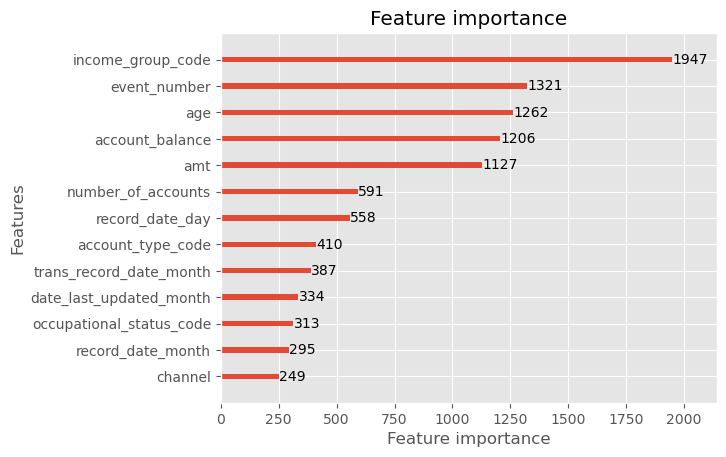

In [39]:
plot_importance(model)

In [40]:
# [(name, imp) for name , imp in zip(lgbm_full.feature_name_, lgbm_full.feature_importances_)]

In [41]:
create_sub_file(test["customer_identifier"], preds, "lgbm_base")

## Using Kfold

In [42]:
X.shape, y.shape

((3600, 13), (3600, 1))

In [43]:
test_data.head()

,record_date_month,income_group_code,number_of_accounts,occupational_status_code,age,date_last_updated_month,account_type_code,account_balance,amt,event_number,channel,record_date_day,trans_record_date_month
0,6,17,19,1,28,9,17.0,700.00,-300.00,71,3,17,6
2,1,12,11,1,40,7,17.0,14063.06,-25.00,1479,3,25,8
194,5,16,8,1,32,7,17.0,17337.58,-4200.00,129,1,30,5
209,5,2,6,1,45,9,9.0,19325.41,-913.20,9000,2,25,11
591,3,9,13,1,29,4,9.0,69.97,-215.27,211,2,28,9


In [44]:
ss.head()

,customer_identifier,declared_net_income
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,29235.978634
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,10695.533087
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,22705.002944
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,12219.649630
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,7810.820056


In [45]:
cfdfd

NameError: name 'cfdfd' is not defined

## Hyperparameters turning